## 時間情報のない集団データ

### 方針

・内部に問題ごとの依存関係を定義し、その関係をもとに遷移させる。

・条件付き確率（遷移確率）と周辺分布の積の和から次の周辺分布を求める。

・まずは遷移過程が部分的にしか分からない人工データを用意し、モデルを学習する。

## 人工データ生成

In [1]:
import numpy as np

# 問題の依存関係の行列 A 
A = np.array([
    [0, 0, 0, 0, 0, 0],  # 初期状態
    [1, 0, 0, 0, 0, 0],  # 問題1は初期状態のみに依存
    [1, 0, 0, 0, 0, 0],  # 問題2は問題1に依存
    [0, 1, 1, 0, 0, 0],  # 問題3は問題2に依存
    [0, 0, 0, 1, 0, 0],  # 問題4は問題2、問題3に依存
    [0, 0, 0, 0, 1, 0]   # 問題4は問題2、問題3に依存
], dtype = float)*3

# 0でない要素の数で割る処理
nonzero_counts = np.count_nonzero(A[1:], axis=1, keepdims=True)
A[1:] = np.where(nonzero_counts != 0, A[1:] / nonzero_counts, 0)

print(A)

# 遷移確率を計算する関数
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # まだ正解していない問題のみ対象
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            solved_problems = X * required_problems  # 現状解けている
            
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            raw_probabilities[i] = np.exp(num_solved)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

[[0.  0.  0.  0.  0.  0. ]
 [3.  0.  0.  0.  0.  0. ]
 [3.  0.  0.  0.  0.  0. ]
 [0.  1.5 1.5 0.  0.  0. ]
 [0.  0.  0.  3.  0.  0. ]
 [0.  0.  0.  0.  3.  0. ]]


In [2]:
# 教師データセットを生成する関数
def generate_training_data(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数
    dataset = []
    
    # 各ステップでデータを生成
    for i in range(1, num_correct_problems + 1):  # 正解させる問題数。別にnum_correct_problems問目は生成する必要ない。
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            input_X = X.copy()
            # i問正解させる
            for k in range(i):

                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
                
            # 初期状態と1ステップ後の状態の差分を教師データとして使用
            target_Y = (X - input_X).clip(min=0)  # 0から1に変わった部分のみを1、他は0

            # print(f"input_X: {input_X}, target_Y: {target_Y}")

            # 初期状態（入力）と差分（教師データ）のペアを保存
            dataset.append((input_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
    return dataset


In [3]:
import torch

# データセットの生成
num_questions = 5  # 問題数
num_data_per_step = 20     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([1, 0, 0, 0, 0, 0])

training_data = generate_training_data(A, X_init, num_questions, num_data_per_step)
train_X = [input_data for input_data, _ in training_data]
train_Y = [target_data for _, target_data in training_data]

# PyTorch テンソルに変換
train_X = torch.tensor(train_X, dtype=torch.float32)
train_Y = torch.tensor(train_Y, dtype=torch.float32)

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_33520/3610591694.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor(train_X, dtype=torch.float32)


In [4]:
import itertools
from collections import defaultdict

# Generate states where the first digit is always 1
states = [(1,) + state for state in itertools.product([0, 1], repeat=num_questions)]
print(f"Number of States: {len(states)}\n")

states = sorted(states, key=lambda state: sum(state))

# Initialize the state counts
state_counts = defaultdict(int)

# Assuming 'dataset' is your list of student results
for result, result2 in training_data:
    # print(result2)
    state_tuple = tuple(map(int, result + result2))  # Convert np.int64 to int
    state_counts[state_tuple] += 1  # Count only if the first digit is 1

print(state_counts)

# Display the counts for each state
for state in states:
    count = state_counts[state]
    formatted_state = list(state)  # Convert tuple to list for the desired format
    print(f"State {formatted_state}: {count} students")

print(state_counts)

Number of States: 32

defaultdict(<class 'int'>, {(1, 1, 0, 0, 0, 0): 10, (1, 0, 1, 0, 0, 0): 8, (1, 0, 0, 0, 0, 1): 1, (1, 0, 0, 1, 0, 0): 1, (1, 1, 1, 0, 0, 0): 14, (1, 1, 0, 1, 0, 0): 4, (1, 1, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0): 1, (1, 1, 1, 1, 0, 0): 11, (1, 1, 1, 0, 0, 1): 4, (1, 1, 1, 0, 1, 0): 3, (1, 1, 0, 1, 1, 0): 1, (1, 0, 1, 1, 1, 0): 1, (1, 1, 1, 1, 1, 0): 13, (1, 1, 1, 1, 0, 1): 3, (1, 1, 1, 0, 1, 1): 2, (1, 0, 1, 1, 1, 1): 1, (1, 1, 0, 1, 1, 1): 1, (1, 1, 1, 1, 1, 1): 20})
State [1, 0, 0, 0, 0, 0]: 0 students
State [1, 0, 0, 0, 0, 1]: 1 students
State [1, 0, 0, 0, 1, 0]: 0 students
State [1, 0, 0, 1, 0, 0]: 1 students
State [1, 0, 1, 0, 0, 0]: 8 students
State [1, 1, 0, 0, 0, 0]: 10 students
State [1, 0, 0, 0, 1, 1]: 0 students
State [1, 0, 0, 1, 0, 1]: 0 students
State [1, 0, 0, 1, 1, 0]: 0 students
State [1, 0, 1, 0, 0, 1]: 0 students
State [1, 0, 1, 0, 1, 0]: 1 students
State [1, 0, 1, 1, 0, 0]: 0 students
State [1, 1, 0, 0, 0, 1]: 0 students
State [1, 1, 0, 0, 1, 0]:

## モデル

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [6]:
import torch
import numpy as np


def _bcsoftmax1d(x, budget):
    """Budget Constrained Softmax function for vector.

    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    x = x - torch.max(x, dim=0)[0] # normalization to avoid numerical errors
    exp_x = torch.exp(x)
    # sorting
    _, indices = torch.sort(budget / exp_x, descending=False)
    exp_x = exp_x[indices]
    budget = budget[indices]
    # find K_B
    r = torch.flip(torch.cumsum(torch.flip(exp_x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    z = r / s
    is_in_KB = torch.logical_and(
        (s - budget) > 0, exp_x / z > budget
    )
    # compute outputs
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # print("s", s, "r", r)
        # print("勾配", torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc))
        assert not torch.isnan(torch.matmul(grad_y, Jx)).any(), "Jx contains NaN"
        assert not torch.isinf(torch.matmul(grad_y, Jx)).any(), "Jx contains Inf"
        assert not torch.isnan(torch.matmul(grad_y, Jc)).any(), "Jc contains NaN"
        assert not torch.isinf(torch.matmul(grad_y, Jc)).any(), "Jc contains Inf"

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [7]:
######### Use these functions! #########
bcsoftmax1d = BCSoftmax1d.apply

# データによってmodelを通す回数が違
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

In [8]:
class Model(nn.Module):
    def __init__(self, num_questions):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_questions, num_questions, bias=False)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

In [9]:
# モデル、損失関数、最適化関数の設定
model = Model(num_questions+1)  # 5問+初期状態の問題を扱うモデル
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 学習

In [10]:
# 学習ループ
num_epochs = 1000  # エポック数
alpha = 0.001 # 正則化パラメータ

# データの確認
assert not torch.isnan(train_X).any(), "train_X contains NaN"
assert not torch.isinf(train_X).any(), "train_X contains Inf"
assert not torch.isnan(train_Y).any(), "train_Y contains NaN"
assert not torch.isinf(train_Y).any(), "train_Y contains Inf"

for epoch in range(num_epochs):
    model.train()  # モデルを訓練モードに
    optimizer.zero_grad()  # 勾配の初期化
    
    outputs = []  # 出力を保持するリスト
    
    # 各データに対して train_Y の値に基づいてループを実行
    for i, target in enumerate(train_Y):
        c = torch.cat([torch.tensor([0.0]), torch.ones(num_questions, dtype=torch.float32)])
        output = train_X[i]  # 各 i 番目の入力データを使用
        output = output.view(-1)
        # target (train_Y[i]) が int 型または float 型であると仮定
        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となるので対応
            if c.sum() <= 1:
                # print("aaaaaaaa")
                output_0 = c
            else:
                output_0 = model(output, c)  # 前回の出力を次のステップの入力として使用
            output = output_0 + output  # 出力を加算
            c = c - output_0  # 予算を更新

        outputs.append(output - train_X[i])  # 最終的な出力を保存

    # outputs を適切な形に変換して損失計算（例えば torch.stack を使用）
    outputs = torch.stack(outputs)
    outputs = outputs.squeeze(1)

    # モデルの出力の確認
    assert not torch.isnan(outputs).any(), "Model output contains NaN"
    assert not torch.isinf(outputs).any(), "Model output contains Inf"

    # L1正則化項の計算
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))

    # 損失の計算
    loss0 = criterion(outputs, train_Y)

    loss = loss0 + alpha * l1_reg  # L1正則化項を追加した損失
    
    # 損失の確認
    assert not torch.isnan(loss).any(), "Loss contains NaN"
    assert not torch.isinf(loss).any(), "Loss contains Inf"
    
    # バックプロパゲーションとパラメータの更新
    loss.backward()
    optimizer.step()
    
    # 100エポックごとに損失を表示
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 学習結果の確認
print("Training complete!")

Epoch [50/1000], Loss: 4.9907
Epoch [100/1000], Loss: 4.9204
Epoch [150/1000], Loss: 4.8793
Epoch [200/1000], Loss: 4.8553
Epoch [250/1000], Loss: 4.8437
Epoch [300/1000], Loss: 4.8368
Epoch [350/1000], Loss: 4.8322
Epoch [400/1000], Loss: 4.8288
Epoch [450/1000], Loss: 4.8263
Epoch [500/1000], Loss: 4.8243
Epoch [550/1000], Loss: 4.8226
Epoch [600/1000], Loss: 4.8211
Epoch [650/1000], Loss: 4.8197
Epoch [700/1000], Loss: 4.8186
Epoch [750/1000], Loss: 4.8178
Epoch [800/1000], Loss: 4.8171
Epoch [850/1000], Loss: 4.8166
Epoch [900/1000], Loss: 4.8161
Epoch [950/1000], Loss: 4.8158
Epoch [1000/1000], Loss: 4.8154
Training complete!


## テスト

In [11]:
test = np.array([1, 1, 0, 0, 0, 0], dtype=np.float32)

# numpy配列をtorch.Tensorに変換
test_tensor = torch.tensor(test, dtype=torch.float32)

model.eval()  # モデルを評価モードに

c_test = torch.ones(num_questions+1, dtype=torch.float32)
c_test = c_test - test_tensor  # 予算を更新

# モデルに入力を渡して出力を得る
output = model(test_tensor, c_test)
print("Output:", output)

Output: tensor([0.0000, 0.0000, 0.9673, 0.0244, 0.0061, 0.0023],
       grad_fn=<BCSoftmax1dBackward>)


### パラメータ

In [12]:
torch.set_printoptions(precision=4, sci_mode=False)# モデルの各パラメータを表示
for param in model.parameters():
    print("a", param)

print("本来の依存関係\n", A)

a Parameter containing:
tensor([[    -0.0006,      0.0002,      0.0013,     -0.0003,     -0.0024,
              0.0005],
        [     2.4456,     -0.0004,      0.0002,      0.0004,      0.0001,
             -0.0001],
        [     1.7977,      1.1136,      0.0008,     -0.0003,      0.0000,
              0.0004],
        [    -1.5045,      0.7345,      0.6520,      0.0013,      0.0011,
              0.0003],
        [    -2.0483,     -0.1118,     -0.0003,      0.0008,     -0.0001,
             -0.0005],
        [    -1.8893,     -1.2506,     -1.3909,     -0.2720,      0.0001,
             -0.0001]], requires_grad=True)
本来の依存関係
 [[0.  0.  0.  0.  0.  0. ]
 [3.  0.  0.  0.  0.  0. ]
 [3.  0.  0.  0.  0.  0. ]
 [0.  1.5 1.5 0.  0.  0. ]
 [0.  0.  0.  3.  0.  0. ]
 [0.  0.  0.  0.  3.  0. ]]


### 評価指標

KLダイバージェンスの計算式

$$ D_{\text{KL}}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)} $$

---

Hellinger距離の計算式

$$ H(p, q) = \frac{1}{\sqrt{2}} \left\| \sqrt{p} - \sqrt{q} \right\|_2 $$

ここで、ユークリッドノルム（L2ノルム）は以下のように定義されます：

$$ \left\| \sqrt{p} - \sqrt{q} \right\|_2 = \sqrt{\sum_{i} \left( \sqrt{p(i)} - \sqrt{q(i)} \right)^2} $$


In [13]:
import numpy as np

def kl_divergence(p, q, epsilon=1e-10):
    """
    KLダイバージェンスを計算する関数（qが0の場合の無限大問題を回避）
    
    Parameters:
        p (numpy.ndarray): 真の確率分布
        q (numpy.ndarray): 予測確率分布
        epsilon (float): スムージングパラメータ（非常に小さい値）
    
    Returns:
        float: KLダイバージェンス
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # pとqにスムージングを適用
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # KLダイバージェンスの計算
    return np.sum(p * np.log(p / q))

def hellinger_distance(p, q):
    """
    Hellinger距離を計算する関数

    Parameters:
        p (numpy.ndarray): 真の分布 [batch_size, num_classes]
        q (numpy.ndarray): 予測分布 [batch_size, num_classes]
    
    Returns:
        float: Hellinger距離の平均値
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    # Hellinger距離の計算式: H(p, q) = (1/√2) * ||√p - √q||_2
    sqrt_p = np.sqrt(p)
    sqrt_q = np.sqrt(q)
    distance = np.sqrt(np.sum((sqrt_p - sqrt_q) ** 2)) / np.sqrt(2)
    return np.mean(distance)

def jensen_shannon_divergence(p, q):
    """
    Jensen-Shannon divergence を計算する関数

    Parameters:
        p (numpy.ndarray): 真の分布 [batch_size, num_classes]
        q (numpy.ndarray): 予測分布 [batch_size, num_classes]
    
    Returns:
        float: Jensen-Shannon divergence の平均値
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)

    # 0 の値があると log(0) が発生するため、微小値を加える
    epsilon = 1e-12
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    
    # 分布の平均 M
    m = 0.5 * (p + q)
    
    # Kullback-Leibler divergence の補助関数
    def kl(a, b):
        return np.sum(a * np.log(a / b))
    
    # JSD の計算: JSD(p || q) = 0.5 * (KL(p || M) + KL(q || M))
    jsd = 0.5 * (kl(p, m) + kl(q, m))
    
    # 各サンプルの平均を返す
    return np.mean(jsd)


def evaluate_model(r, p, q):
    """
    遷移確率の真値と予測値の類似性を評価する関数
    :param r: 各ノードの重み (np.array)
    :param p: 各ノードの真の遷移確率 (2D np.array: ノード数 x 遷移確率)
    :param q: 各ノードの予測遷移確率 (2D np.array: ノード数 x 遷移確率)
    :return: 評価指標 L
    """
    L = 0
    for k in range(len(r)):
        L += r[k] * kl_divergence(p[k], q[k])
    return L

In [14]:
node_probabilities = defaultdict(float)
KL = 0
HD = 0
JSD = 0
start = (1,) + tuple(0 for _ in range(num_questions))
node_probabilities[start] = 1

for state in states:
    probabilities = calculate_transition_probabilities(A, np.array(state))

    # 最下層から頂点までのノードの分布を順に計算
    for i in range(num_questions + 1):
        if state[i] == 0:  # まだ解けていない問題
            # 遷移後の状態
            next_state = list(state)
            next_state[i] = 1
            next_state = tuple(next_state)
            node_probabilities[next_state] += probabilities[i] * node_probabilities[state]
    
    # budgetの計算
    c_g = torch.ones(num_questions+1, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)

    # 状態とその予測分布
    state_tensor = torch.tensor(state, dtype=torch.float32)
    predicted_values = model(state_tensor, c_g)  # 予測値を計算

   # 評価指標の計算
    kl = node_probabilities[state] * kl_divergence(probabilities, predicted_values.detach())
    hd = node_probabilities[state] * hellinger_distance(probabilities, predicted_values.detach())
    jsd = node_probabilities[state] * jensen_shannon_divergence(probabilities, predicted_values.detach())
    print(f"状態: {state}, ノード分布: {node_probabilities[state]:.3g}, KL: {kl:.3g}, HD: {hd:.3g}, JSD: {jsd:.3g}")
    print(f"真の遷移確率: {probabilities}, 予測遷移確率: {predicted_values}")
    KL += kl
    HD += hd
    JSD += jsd

print(f"KLダイバージェンス: {KL}")
print(f"Hellinger距離: {HD}")
print(f"Jensen-Shannonダイバージェンス: {JSD}")

状態: (1, 0, 0, 0, 0, 0), ノード分布: 1, KL: 0.0728, HD: 0.131, JSD: 0.0171
真の遷移確率: [0.         0.46525451 0.46525451 0.02316366 0.02316366 0.02316366], 予測遷移確率: tensor([0.0000, 0.6383, 0.3339, 0.0123, 0.0071, 0.0084],
       grad_fn=<BCSoftmax1dBackward>)
状態: (1, 0, 0, 0, 0, 1), ノード分布: 0.0232, KL: 0.00151, HD: 0.00289, JSD: 0.000359
真の遷移確率: [0.         0.47628706 0.47628706 0.02371294 0.02371294 0.        ], 予測遷移確率: tensor([0.0000, 0.6436, 0.3368, 0.0124, 0.0072, 0.0000],
       grad_fn=<BCSoftmax1dBackward>)
状態: (1, 0, 0, 0, 1, 0), ノード分布: 0.0232, KL: 0.0226, HD: 0.00873, JSD: 0.00285
真の遷移確率: [0.         0.32789174 0.32789174 0.01632477 0.         0.32789174], 予測遷移確率: tensor([0.0000, 0.6429, 0.3363, 0.0124, 0.0000, 0.0084],
       grad_fn=<BCSoftmax1dBackward>)
状態: (1, 0, 0, 1, 0, 0), ノード分布: 0.0232, KL: 0.0239, HD: 0.00888, JSD: 0.00293
真の遷移確率: [0.         0.32789174 0.32789174 0.         0.32789174 0.01632477], 予測遷移確率: tensor([0.0000, 0.6477, 0.3386, 0.0000, 0.0072, 0.0065],
       grad_fn=<

### 図示

tensor([0., 1., 1., 1., 1., 1.])
tensor([[1., 0., 0., 0., 0., 0.]])
tensor(0.)
State: (1, 0, 0, 0, 0, 0), Probabilities: [0.         0.46525451 0.46525451 0.02316366 0.02316366 0.02316366], Predicted Values: tensor([0.0000, 0.6383, 0.3339, 0.0123, 0.0071, 0.0084],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 1., 1., 0.])
tensor([[1., 0., 0., 0., 0., 1.]])
tensor(0.)
State: (1, 0, 0, 0, 0, 1), Probabilities: [0.         0.47628706 0.47628706 0.02371294 0.02371294 0.        ], Predicted Values: tensor([0.0000, 0.6436, 0.3368, 0.0124, 0.0072, 0.0000],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 1., 0., 1.])
tensor([[1., 0., 0., 0., 1., 0.]])
tensor(0.)
State: (1, 0, 0, 0, 1, 0), Probabilities: [0.         0.32789174 0.32789174 0.01632477 0.         0.32789174], Predicted Values: tensor([0.0000, 0.6429, 0.3363, 0.0124, 0.0000, 0.0084],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 0., 1., 1.])
tensor([[1., 0., 0., 1., 0., 0.]])
tensor(0.)
State: (1, 0

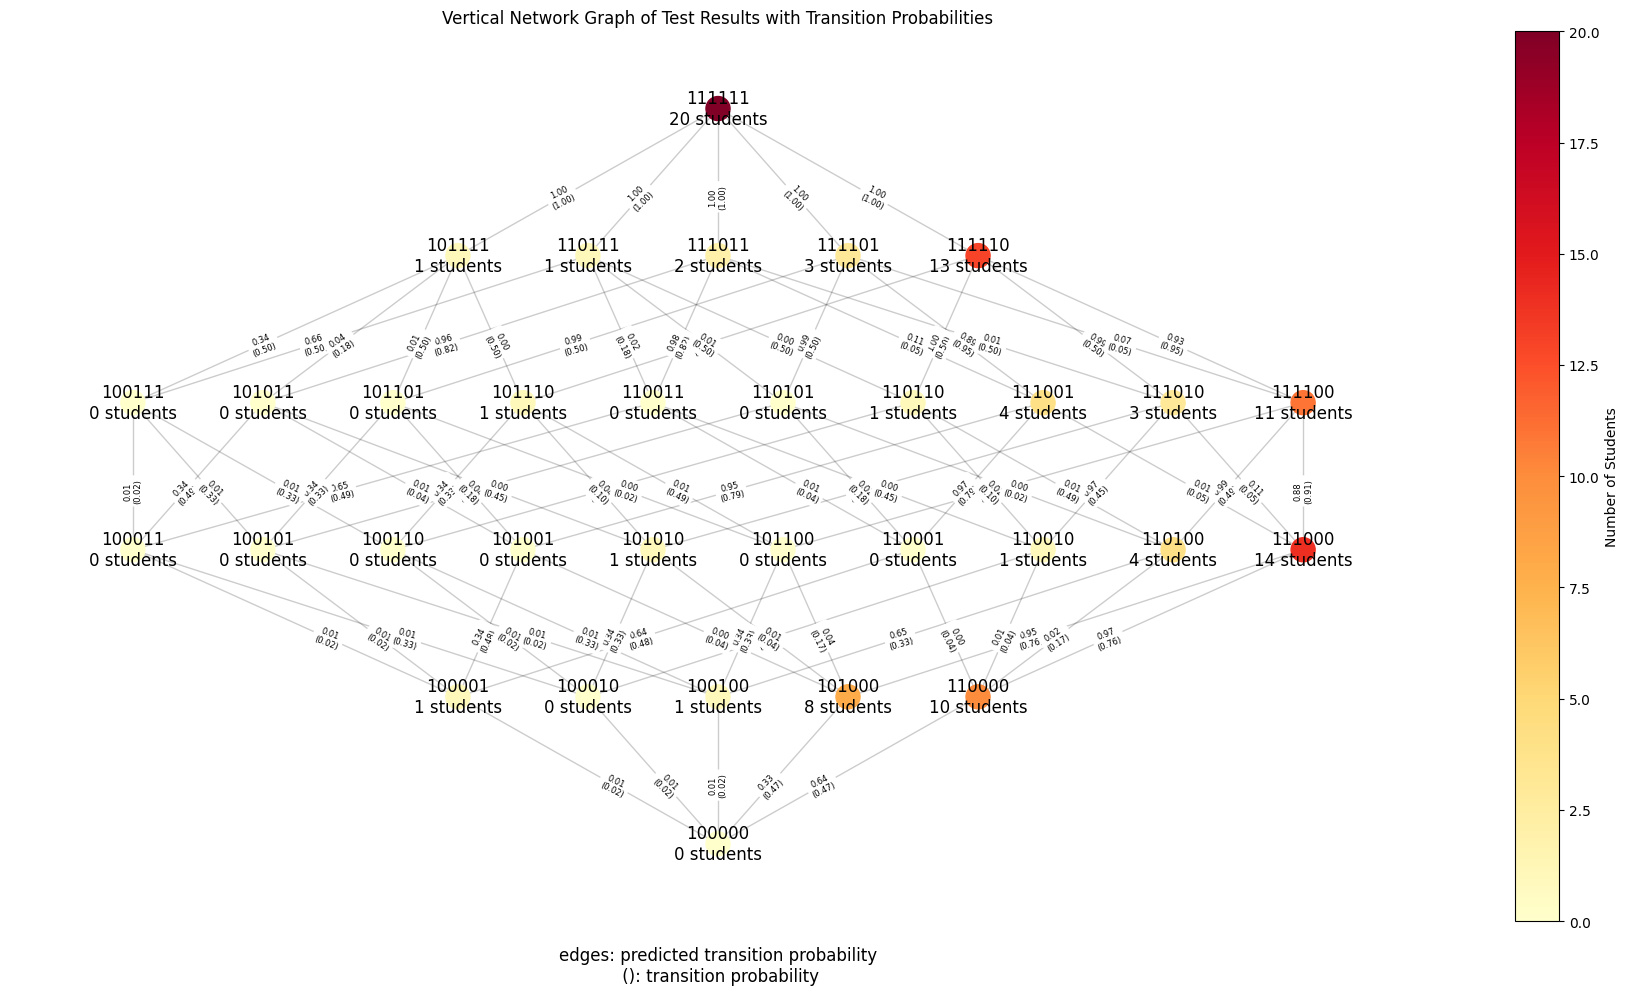

State counts:
State 100000: 0 students
State 110000: 10 students
State 101000: 8 students
State 100001: 1 students
State 100100: 1 students
State 100010: 0 students
State 111000: 14 students
State 110100: 4 students
State 110010: 1 students
State 101010: 1 students
State 100011: 0 students
State 100101: 0 students
State 100110: 0 students
State 101001: 0 students
State 101100: 0 students
State 110001: 0 students
State 111100: 11 students
State 111001: 4 students
State 111010: 3 students
State 110110: 1 students
State 101110: 1 students
State 100111: 0 students
State 101011: 0 students
State 101101: 0 students
State 110011: 0 students
State 110101: 0 students
State 111110: 13 students
State 111101: 3 students
State 111011: 2 students
State 101111: 1 students
State 110111: 1 students
State 111111: 20 students


In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_questions):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_questions)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    probabilities = calculate_transition_probabilities(A, np.array(state))
    c_g = torch.ones(num_questions+1, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)  # 予算を更新
    print(c_g)
    print(torch.tensor([state], dtype=torch.float32))
    state_tensor = torch.tensor(state, dtype=torch.float32)
    print(state_tensor[1])
    predicted_values = model(state_tensor, c_g)  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"({probabilities[i]:.2f})"
                predicted_value = f"{predicted_values[i]:.2f}"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{predicted_value}\n{transition_probability}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.6)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
plt.text(
    0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
    "edges: predicted transition probability\n (): transition probability",  # 表示したいテキスト
    horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
    verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
    transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
    fontsize=12,                    # フォントサイズ
    color="black"                   # テキストの色
)

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")